In [72]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

# Hyperparameters
batch_size = 32
block_size = 8
n_embd = 32
head_size = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [73]:
with open('jfk-speeches.txt', encoding="utf-8") as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)

# Character to integer mapping
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: [itos[i] for i in l]

In [74]:
data = torch.tensor(encode(text), dtype=torch.long)

n = int(len(data) * 0.8)
training_data = data[:n]
validation_data = data[n:]

def get_batch(split):
    training_data if split == 'train' else validation_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # print(ix.shape)
    x = torch.stack([data[i: i + block_size] for i in ix])
    # print(x.shape)
    y = torch.stack([data[i + 1: i + block_size + 1] for i in ix])

    return x, y

xb, yb = get_batch('train')

In [75]:
'''
This is from Dynamig TanH paper that was just published. 
'''

class DyT(nn.Module):
    def __init__(self, num_features, alpha_init_value=0.5):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(1) * alpha_init_value)
        self.weight = nn.Parameter(torch.ones(num_features))
        self.bias = nn.Parameter(torch.zeros(num_features))
    
    def forward(self, x):
        x = torch.tanh(self.alpha * x)
        return x * self.weight + self.bias

In [76]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('mask', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        keys = self.key(x)
        queries = self.query(x)
        values = self.value(x)

        # attention_scores = queries * keys^T
        attention_scores = torch.matmul(queries, keys.transpose(1, 2))

        # divide since otherwise softmax will explode. Single token will dominate.
        attention_scores = attention_scores / (C ** 0.5)
        attention_scores = attention_scores.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
        attention_probs = F.softmax(attention_scores, dim=-1)
        output = attention_probs @ values

        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, head_size, num_heads):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.project = nn.Linear(num_heads * head_size, n_embd)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        head_outputs = [head(x) for head in self.heads]
        output = torch.cat(head_outputs, dim=-1)
        output = self.project(output)
        output = self.dropout(output)
        return output

class ModelBase(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.transformer = Transformer()
        self.positional_embedding = nn.Embedding(block_size, n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.pre_ln = nn.LayerNorm(n_embd) # pre layer norm

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.ones_(module.weight)
            torch.nn.init.zeros_(module.bias)

    def forward(self, input, targets=None): # input is B * T (batch size * block size)

        token_embeddings = self.token_embedding(input)
        positional_embeddings = self.positional_embedding(torch.arange(input.shape[1], device=device))
        embeddings = token_embeddings + positional_embeddings
        output = self.transformer(embeddings)
        output = self.pre_ln(output)

        logits = self.lm_head(output)

        if targets is None:
            return logits, None
        else:
            B, T, C = logits.shape

            logits = logits.view(B * T, C)
            targets = targets.view(B * T)

            loss = F.cross_entropy(logits, targets)

            return logits, loss

        # logits = self.token_embedding(input)

        # B, T, C = logits.shape
        # logits = logits.view(B * T, C)
        # targets = targets.view(B * T)
        # loss = F.cross_entropy(logits, targets)

        # return logits, loss
    
    def generate(self, idx, max_tokens):
        # Get rid of list append - work with tensors instead
        for _ in range(max_tokens):
            # crop idx to block_size tokens if longer
            idx_cond = idx[:, -block_size:]
            # get predictions
            logits, _ = self(idx_cond, None)
            # print("logits shape", logits.shape)
            # focus on last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # get probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append to sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(0.1)
        )
    
    def forward(self, x):
        return self.net(x)

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.layerNorm1 = nn.LayerNorm(n_embd)
        self.layerNorm2 = nn.LayerNorm(n_embd)
        self.attention = MultiHeadAttention(head_size, 8)
        self.feed_forward = FeedForward()

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x + self.dropout(self.attention(self.layerNorm1(x)))
        x = x + self.dropout(self.feed_forward(self.layerNorm2(x)))

        return x

In [ ]:
@torch.no_grad()  # disable gradient tracking for efficiency
def estimate_loss():
    out = {}
    m.eval()  # set model to evaluation mode
    for split in ['train', 'val']:
        losses = torch.zeros(200)
        for k in range(200):
            X, Y = get_batch(split)
            logits, loss = m(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()  # set model back to training mode
    return out

def get_lr_lambda(warmup_steps=1000):
    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        progress = float(step - warmup_steps) / float(max(1, 5000 - warmup_steps))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return lr_lambda

m = ModelBase(vocab_size)
m = m.to(device)
# optimizer = torch.optim.Adam(m.parameters(), lr=0.00005)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)

logits, loss = m(xb, yb)
# print("loss is", loss.item())
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda())


In [78]:
train_losses = []
val_losses = []
gradient_norms = []

for i in range(5000):

    if i % 500 == 0:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        print(f"step {i}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    
    xb, yb = get_batch('train')
    logits, loss = m(xb, yb)
    # print("loss is", loss.item())
    
    total_norm = 0
    for p in m.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    gradient_norms.append(total_norm)

    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_norm_(m.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    if i % 100 == 0:
        print(f"step {i}: loss {loss.item()}")

step 0: train loss 4.3111, val loss 4.3107
step 0: loss 4.307524681091309
step 100: loss 2.689180612564087
step 200: loss 2.561448097229004
step 300: loss 2.328181505203247
step 400: loss 2.4459242820739746
step 500: train loss 2.3066, val loss 2.3029
step 500: loss 2.2751684188842773
step 600: loss 2.2285852432250977
step 700: loss 2.3246095180511475
step 800: loss 2.2738375663757324
step 900: loss 2.3189191818237305
step 1000: train loss 2.2376, val loss 2.2415
step 1000: loss 2.2923245429992676
step 1100: loss 2.0367674827575684
step 1200: loss 2.3251750469207764
step 1300: loss 2.2015297412872314
step 1400: loss 2.2589080333709717
step 1500: train loss 2.2110, val loss 2.2158
step 1500: loss 2.3046412467956543
step 1600: loss 2.1409919261932373
step 1700: loss 2.3828682899475098
step 1800: loss 2.165573835372925
step 1900: loss 2.255784749984741
step 2000: train loss 2.1316, val loss 2.1314
step 2000: loss 2.092702865600586
step 2100: loss 2.261195421218872
step 2200: loss 2.103463

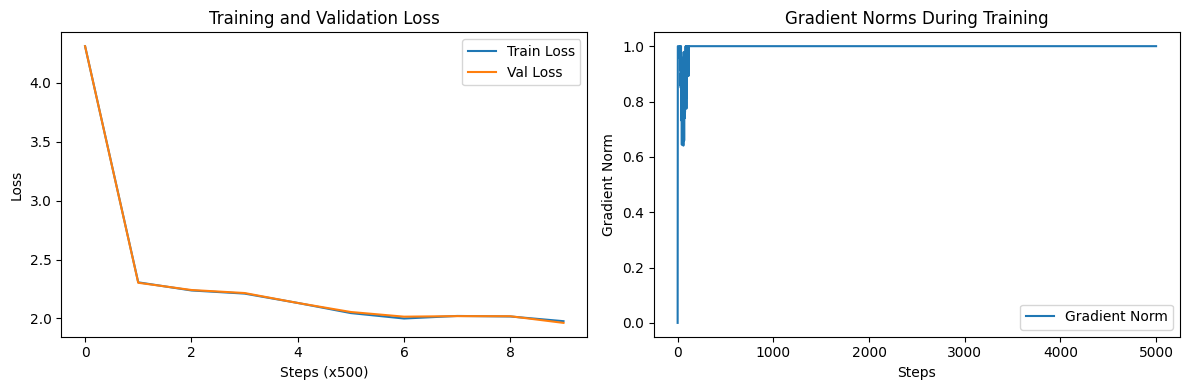

In [79]:
plt.figure(figsize=(12, 4))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Steps (x500)')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot gradient norms
plt.subplot(1, 2, 2)
plt.plot(gradient_norms, label='Gradient Norm')
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms During Training')
plt.legend()

plt.tight_layout()
plt.show()

In [80]:
# Initialize context with a single token
context = torch.zeros((1, 1), dtype=torch.long, device=device)
# Generate 100 new tokens
generated_tokens = m.generate(context, max_tokens=500)[0].tolist()
# Convert tokens to text
generated_text = ''.join([itos[i] for i in generated_tokens])
print(generated_text)


Besed omireds rencempporcaian and and irress and thisce have kghien wored solpaty of the heear pregrets it I we un to mperovil a and and tut the have obgoure rethize the wherce i thosts all For as bearkease, intuerstheist fredman leadure thest thosand of forech Thime stry plity toders a sy orgcingurge imviss pracaly arsk, aangteshe peysetm. Nan Nattiions amewe, ;Eurear dessfort reemation. I a strom or netitucan. That a binity, no--morica trates. Wow Lentr ther hist filittity. He pledgear and tea


In [61]:
'''
smaller batch sizes lead to noisier gradients.

lr = 0.001: loss is 1.969
lr = 0.0001: loss is 2.09

added layer norm before attention: loss is 2.122
added weight initialization: loss is 1.96

added residual dropout on transformer class: loss is 1.88

Stabilize Training: preventin loss bouncing up and down.

batch size 64 and lr = 0.0001: loss is 2.085 but gradients seem to be more stable
added kaiming initialization: loss is 1.96

increased block size to 16: loss is 2.45
increased embd size to 64: loss is 2.30

'''

'\nsmaller batch sizes lead to noisier gradients.\n\nlr = 0.001: loss is 1.969\nlr = 0.0001: loss is 2.09\n\nadded layer norm before attention: loss is 2.122\nadded weight initialization: loss is 1.96\n\nadded residual dropout on transformer class: loss is 1.88\n\nStabilize Training: preventin loss bouncing up and down.\n\nbatch size 64 and lr = 0.0001: loss is 2.085 but gradients seem to be more stable\nadded kaiming initialization: loss is 1.96\n\nincreased block size to 16: loss is 2.45\nincreased embd size to 64: loss is 2.30\n\n'